In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import seaborn as sns
import itertools
from tqdm import tqdm_notebook as tqdm
from scipy import stats as st
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, get_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [69]:
!ls /datasets/Churn*

/datasets/Churn.csv


In [70]:
data = pd.read_csv('/datasets/Churn.csv')

In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [72]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [73]:
data.CustomerId.nunique()

10000

No duplicates in CustomerId

In [74]:
for col in ['Geography', 'Tenure', 'NumOfProducts']:
    print(f'{col} unique values: {data[col].unique()}')

Geography unique values: ['France' 'Spain' 'Germany']
Tenure unique values: [ 2.  1.  8.  7.  4.  6.  3. 10.  5.  9.  0. nan]
NumOfProducts unique values: [1 3 2 4]


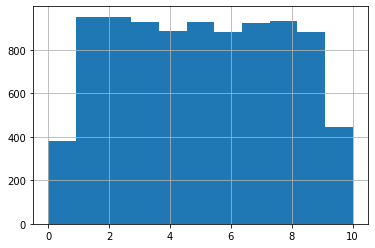

In [75]:
data.Tenure.hist(bins=11)

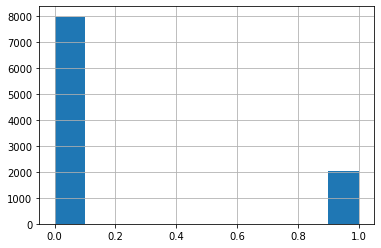

In [76]:
data.Exited.hist()

We have the dataset with 10000 records. Each record corresponds to unique customer Id number thus no duplicated raws and we have missing values only in the 'Tenure' columns. Our dependent variable is in the 'Exited' column and we may clearly see that it's unbalanced one

## Data preprocessing and splitting

Most likely the missing values in Tenure columns stands for the clients who don't have any deposits to define the period of maturation and this is the value to keep. we have values in the column from 0 to 10 representing the the periods of maturations with meaningfull order thus if we replace the missing values with -1 it'll separate the missing values and put it just below the shortest deposits which make sense.

In [77]:
data.Tenure.fillna(-1, inplace=True)
data.isna().any()

RowNumber          False
CustomerId         False
Surname            False
CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

Before doing any more explorations we should put aside the test set to avoid the leakage of information from the test set. We'll drop away the identification information like row number, customer Id or surname - they won't help in training the models

In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Exited', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
    , data['Exited'], test_size=0.25, stratify=data['Exited'], random_state=123
)
X_train.shape, X_test.shape

((7500, 10), (2500, 10))

In [79]:
X_train.head(1)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
5432,599,Spain,Male,51,0.0,0.0,1,1,1,175235.99


## Feature encoding

We have two clearly categorical feature: Geography and Gender. we can't order them so one hot encoding is the best option here.

In [80]:
X_train = pd.get_dummies(X_train, columns=['Geography', 'Gender'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Geography', 'Gender'], drop_first=True)
X_train.head(1)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
5432,599,51,0.0,0.0,1,1,1,175235.99,0,1,1


Let's take a look at the numeric columns

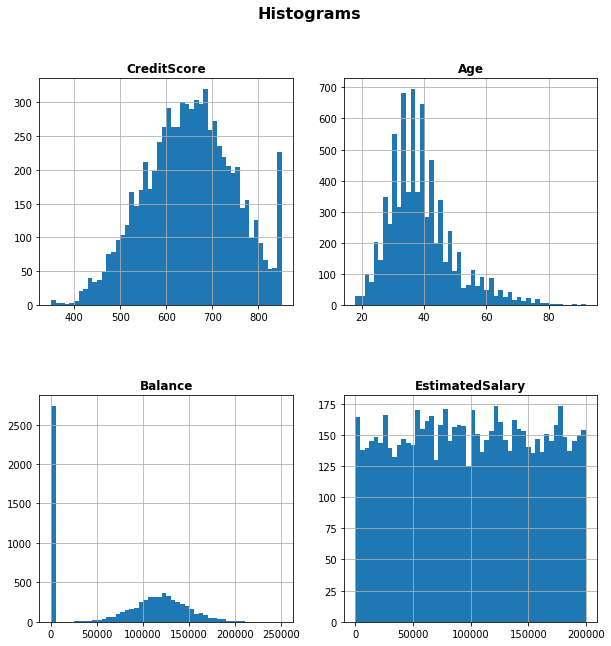

In [81]:
col_for_hist = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
fig, axes = plt.subplots(2,2, figsize=(10,10))
fig.subplots_adjust(wspace=.2, hspace=.4)
for i, col in enumerate(col_for_hist):
    X_train[col].hist(bins=50, ax=axes[i//2,i%2])
    axes[i//2,i%2].set_title(col, fontweight='bold', size=12)
    
plt.suptitle('Histograms', fontweight='bold', size=16)
plt.show()

It is quite possible that for the features above we should look for grouping to turn them into categories of customers. But due to the fact that we are going to work mostly with tree-based algorithms we'll leave them as they are - decision tree will split them into groups for us. For the same reason we don't need to do any scaling of the data - scaling won't affect the  tree-based models performance.

## Models without taking into account the imbalance

We are going to try three classic ML models for this task: Decision Tree, Random Forest and Logistic Regression. Next we define the global parameter grids for them and use the pipeline to scale the data before applying Logistic Regression

In [82]:
dt_params = {'max_depth': range(5, 11)
             , 'min_impurity_decrease': [0.1 * 10**(-x) for x in range(2,5)]
            }

# Initial search was made for these parameters
## ************* it took around 2 hours to run the notebook with this grid for me ***********
rf_params = {'max_depth': range(7, 15)
             , 'min_impurity_decrease': [0.1 * 10**(-x) for x in range(3,5)]
          , 'n_estimators': range(80, 151, 10)
            }

# The smaller version of parameter grid for saving time when rerun the code, results were 
# similar but the text comments was made based on full param-grid for Random Forest
#rf_params = {'max_depth': [7, 11, 14]
#             , 'min_impurity_decrease': [0.1 * 10**(-x) for x in range(3,5)]
#          , 'n_estimators': [80, 110, 150]
#            }

# Pipe (we don't need to scale indicator columns but no harm if we do)
lr_pipe = Pipeline([('scaler', StandardScaler())
                    , ('estimator', LogisticRegression(solver='liblinear'))])

lr_pipe_params = {'estimator__C': [0.001, 0.01, 0.1, 1, 5, 10, 50, 100]
                  , 'estimator__penalty': ['l1', 'l2']
                 }

To find the optimal global parameters we'll use the scikit-learn's GridSearchCV. It rely on the cross validation technique which is better then testing on one validation set. The only minus of the function for us is that we cannot easily seed it to be certain of the same results for every go. But shouldn't be a problem because we expect our best results after taking into account the imbalance of the data...

In [83]:
# helper function
def global_param_tune(X_train, y_train, clf, param_grid, cv=5, scoring='f1', verbose=0):
    search = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, return_train_score=True)
    search.fit(X_train, y_train)
    if verbose == 1:
        means = search.cv_results_['mean_test_score']
        stds = search.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, search.cv_results_['params']):
            print(f'CV score {mean:0.4f} (+/-{std:0.4f}) for {params}')
    print(f'Best CV score {search.best_score_:0.3f} for parameters: {search.best_params_}')
    return search.best_estimator_, search.best_score_

Now we'll find the optimal parameters for all three models and train the tuned classifiers for later final testing. Also we'll keep the CV scores in the dataframe to choose optimal model based on cross validation

In [84]:
cv_scores = pd.DataFrame(columns=['Decision Tree', 'Random Forest', 'Logistic Regression']
                         , index=['Initial Data', 'Upsampled Data', 'Downsampled Data']
                        )

In [85]:
%%time
dt_clf, dt_cv_scores = global_param_tune(X_train, y_train, DecisionTreeClassifier()
                                         , dt_params, verbose=0)
cv_scores.loc['Initial Data', 'Decision Tree'] = dt_cv_scores
dt_clf.fit(X_train, y_train)

Best CV score 0.563 for parameters: {'max_depth': 9, 'min_impurity_decrease': 0.0001}
CPU times: user 2.84 s, sys: 0 ns, total: 2.84 s
Wall time: 2.85 s


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0001, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [86]:
%%time
rf_clf, rf_cv_scores = global_param_tune(X_train, y_train, RandomForestClassifier()
                                       , rf_params, verbose=0)
cv_scores.loc['Initial Data', 'Random Forest'] = rf_cv_scores
rf_clf.fit(X_train, y_train)

Best CV score 0.577 for parameters: {'max_depth': 14, 'min_impurity_decrease': 1e-05, 'n_estimators': 110}
CPU times: user 10min 23s, sys: 1.57 s, total: 10min 24s
Wall time: 10min 29s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=1e-05, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=110,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [87]:
%%time
lr_pipe_clf, lr_pipe_cv_scores = global_param_tune(X_train, y_train, lr_pipe
                                                   , lr_pipe_params, verbose=0)
cv_scores.loc['Initial Data', 'Logistic Regression'] = lr_pipe_cv_scores
lr_pipe_clf.fit(X_train, y_train)

Best CV score 0.329 for parameters: {'estimator__C': 1, 'estimator__penalty': 'l1'}
CPU times: user 10.1 s, sys: 7.73 s, total: 17.8 s
Wall time: 17.9 s


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('estimator',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

Best crossvalidation score goes to Random Forest model so far

## Upsampling

Let's try to improve the models with upsampling the dataset. Unfortunately we won't be able to use GridSearchCV with upsampling (actually we could with imblearn.pipeline but I'm not sure how to downsample this way) so we'll do parameter tuning and cross_validation manually

Firstly define some helper functions

In [88]:
def upsample(features, target, repeat):
    """
    Upsample the data with target=1
    features - pandas dataframe with features
    target - pandas Series with target variable, should be binary - [0,1]
    repeat - int, how many times to repeat samples with target=1
    """
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=123)
    
    return features_upsampled, target_upsampled

def downsample(features, target, fraction):
    """
    Downsample the data with target=0
    features - pandas dataframe with features
    target - pandas Series with target variable, should be binary - [0,1]
    fraction - float should be in interval (0,1)
    , represent fraction of samples with target=0 to keep
    """
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=123)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=123)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=123)
    
    return features_downsampled, target_downsampled

In [89]:
def score_model(X_train, y_train, clf, params, cv=5, up=0, down=0, scoring='f1', random_state=123):
    """
    Compute the cross validation scores for
    X_train - features
    y_train - targets
    clf - model
    params - parameters for model
    cv - integer, to specify the number of folds
    up - times to oversample the ones
    down - share of zeros to use
    scoring - string with name of the scorer (standard sklearn name)
    random_state - seed the folds
    return array with validation scores
    """
    cv = StratifiedKFold(n_splits=cv, random_state=random_state)
    scores = []
    scorer = get_scorer(scoring)
    for train_fold_index, val_fold_index in cv.split(X_train, y_train):
        
        X_train_fold, y_train_fold = X_train.iloc[train_fold_index], y_train.iloc[train_fold_index]
        X_val_fold, y_val_fold = X_train.iloc[val_fold_index], y_train.iloc[val_fold_index]
        
        if up > 0:
            X_train_fold_mod, y_train_fold_mod = upsample(X_train_fold, y_train_fold, up)
        elif down > 0:
            X_train_fold_mod, y_train_fold_mod = downsample(X_train_fold, y_train_fold, down)
        else:
            X_train_fold_mod, y_train_fold_mod = X_train_fold, y_train_fold
        
        model = clf.set_params(**params).fit(X_train_fold_mod, y_train_fold_mod)
        scores.append(scorer(model, X_val_fold, y_val_fold))
    return np.array(scores)

In [90]:
def global_param_tune_manual(X_train, y_train, clf, param_grid, cv=5, scoring='f1'
                             , verbose=0, up=0, down=0, random_state=123):
    """
    Find optimal parameter set for the model with specified upsample or downsample
    X_train - features
    y_train - targets
    clf - model
    param_grid - dictionary of parameters to optimize
    cv - integer, to specify the number of folds
    up - times to oversample the ones
    down - share of zeros to use
    scoring - string with name of the scorer (standard sklearn name)
    random_state - seed the score_model function
    return best CV score and best parameters from param_grid
    """
    # create list of param combinations in param_grid
    keys = param_grid.keys()
    values = (param_grid[key] for key in keys)
    params = [dict(zip(keys, combination)) for combination in itertools.product(*values)]
    # loop through params
    score_tracker = []
    for param in params:
        scores = score_model(X_train, y_train, clf, param, cv=cv
                             , up=up, down=down, scoring=scoring, random_state=random_state)
        score_tracker.append((scores.mean(), param))
        # print the info if needed
        if verbose >0:
            print(f'CV score {scores.mean():0.4f} (+/- {scores.std():0.4f}) for {param}')
    best_scores = sorted(score_tracker, key=lambda x: x[0], reverse=True)[0]
    print(f'Best CV score {best_scores[0]:0.4f} for parameters: {best_scores[1]}')
    return best_scores

In [91]:
%%time
score_tracker = []
for up in tqdm(range(1,4)):
    print(f'Upsample with up={up}')
    score, params = global_param_tune_manual(X_train, y_train, DecisionTreeClassifier(), dt_params, up=up)
    score_tracker.append((up, score, params))
dt_up, score, dt_params_up = sorted(score_tracker, key=lambda x: x[1], reverse=True)[0]

X_train_up, y_train_up = upsample(X_train, y_train, dt_up)
dt_clf_up = DecisionTreeClassifier(**dt_params_up).fit(X_train_up, y_train_up)
cv_scores.loc['Upsampled Data', 'Decision Tree'] = score
print(f'Best score for upsample is {score:0.4f} for up={dt_up} and params: {dt_params_up}')

Upsample with up=1
Best CV score 0.5623 for parameters: {'max_depth': 9, 'min_impurity_decrease': 0.0001}
Upsample with up=2
Best CV score 0.6042 for parameters: {'max_depth': 8, 'min_impurity_decrease': 0.001}
Upsample with up=3
Best CV score 0.5966 for parameters: {'max_depth': 7, 'min_impurity_decrease': 0.001}

Best score for upsample is 0.6042 for up=2 and params: {'max_depth': 8, 'min_impurity_decrease': 0.001}
CPU times: user 13 s, sys: 15.5 ms, total: 13 s
Wall time: 13.2 s


In [92]:
%%time
score_tracker = []
for up in tqdm(range(1,4)):
    print(f'Upsample with up={up}')
    score, params = global_param_tune_manual(X_train, y_train, RandomForestClassifier(), rf_params, up=up)
    score_tracker.append((up, score, params))
rf_up, rf_score, rf_params_up = sorted(score_tracker, key=lambda x: x[1], reverse=True)[0]
X_train_up, y_train_up = upsample(X_train, y_train, rf_up)
rf_clf_up = RandomForestClassifier(**rf_params_up).fit(X_train_up, y_train_up)
cv_scores.loc['Upsampled Data', 'Random Forest'] = rf_score
print(f'Best score for upsample is {rf_score:0.4f} for up={rf_up} and params: {rf_params_up}')

Upsample with up=1
Best CV score 0.5733 for parameters: {'max_depth': 13, 'min_impurity_decrease': 1e-05, 'n_estimators': 90}
Upsample with up=2
Best CV score 0.6159 for parameters: {'max_depth': 11, 'min_impurity_decrease': 0.0001, 'n_estimators': 150}
Upsample with up=3
Best CV score 0.6214 for parameters: {'max_depth': 9, 'min_impurity_decrease': 0.0001, 'n_estimators': 90}

Best score for upsample is 0.6214 for up=3 and params: {'max_depth': 9, 'min_impurity_decrease': 0.0001, 'n_estimators': 90}
CPU times: user 33min, sys: 4.74 s, total: 33min 5s
Wall time: 33min 21s


In [93]:
%%time
score_tracker = []
for up in tqdm(range(2,5)):
    print(f'Upsample with up={up}')
    score, params = global_param_tune_manual(X_train, y_train, lr_pipe, lr_pipe_params, up=up)
    score_tracker.append((up, score, params))
lr_up, lr_score, lr_params_up = sorted(score_tracker, key=lambda x: x[1], reverse=True)[0]

X_train_up, y_train_up = upsample(X_train, y_train, lr_up)
lr_clf_up = lr_pipe.set_params(**lr_params_up).fit(X_train_up, y_train_up)
cv_scores.loc['Upsampled Data', 'Logistic Regression'] = lr_score
print(f'Best score for upsample is {lr_score:0.4f} for up={lr_up} and params: {lr_params_up}')

Upsample with up=2
Best CV score 0.4837 for parameters: {'estimator__C': 0.1, 'estimator__penalty': 'l2'}
Upsample with up=3
Best CV score 0.5127 for parameters: {'estimator__C': 0.01, 'estimator__penalty': 'l1'}
Upsample with up=4
Best CV score 0.5093 for parameters: {'estimator__C': 0.01, 'estimator__penalty': 'l1'}

Best score for upsample is 0.5127 for up=3 and params: {'estimator__C': 0.01, 'estimator__penalty': 'l1'}
CPU times: user 28.8 s, sys: 19.2 s, total: 48 s
Wall time: 48.1 s


Upsampling helps a lot. Even Logistic Regression model scores decent 51%. But no doubt Random Forest still the best approach with almost 62% CV score.

## Downsampling

Let's see what result we can achieve with another way to balance the data

In [100]:
%%time
score_tracker = []
for down in tqdm(np.arange(0.35, 0.71, 0.05)):
    print(f'Downsample with down={down:0.2f}')
    score, params = global_param_tune_manual(X_train, y_train, DecisionTreeClassifier(), dt_params, down=down)
    score_tracker.append((down, score, params))
dt_down, dt_score, dt_params_down = sorted(score_tracker, key=lambda x: x[1], reverse=True)[0]

X_train_down, y_train_down = downsample(X_train, y_train, dt_down)
dt_clf_down = DecisionTreeClassifier(**dt_params_down).fit(X_train_down, y_train_down)
cv_scores.loc['Downsampled Data', 'Decision Tree'] = dt_score
print(f'Best score for downsample is {dt_score:0.4f} for  down={dt_down} and params: {dt_params_down}')

Downsample with down=0.35
Best CV score 0.5946 for parameters: {'max_depth': 8, 'min_impurity_decrease': 0.001}
Downsample with down=0.40
Best CV score 0.6063 for parameters: {'max_depth': 7, 'min_impurity_decrease': 0.001}
Downsample with down=0.45
Best CV score 0.5987 for parameters: {'max_depth': 7, 'min_impurity_decrease': 0.001}
Downsample with down=0.50
Best CV score 0.6061 for parameters: {'max_depth': 8, 'min_impurity_decrease': 0.001}
Downsample with down=0.55
Best CV score 0.5994 for parameters: {'max_depth': 10, 'min_impurity_decrease': 0.001}
Downsample with down=0.60
Best CV score 0.5935 for parameters: {'max_depth': 8, 'min_impurity_decrease': 0.001}
Downsample with down=0.65
Best CV score 0.6055 for parameters: {'max_depth': 9, 'min_impurity_decrease': 0.001}
Downsample with down=0.70
Best CV score 0.5887 for parameters: {'max_depth': 9, 'min_impurity_decrease': 0.001}

Best score for downsample is 0.6063 for  down=0.39999999999999997 and params: {'max_depth': 7, 'min_im

In [101]:
%%time
score_tracker = []
for down in tqdm(np.arange(0.35, 0.71, 0.05)):
    print(f'Downsample with down={down:0.2f}')
    score, params = global_param_tune_manual(X_train, y_train, RandomForestClassifier(), rf_params, down=down)
    score_tracker.append((down, score, params))
rf_down, rf_score, rf_params_down = sorted(score_tracker, key=lambda x: x[1], reverse=True)[0]
X_train_down, y_train_down = downsample(X_train, y_train, rf_down)
rf_clf_down = RandomForestClassifier(**rf_params_down).fit(X_train_down, y_train_down)
cv_scores.loc['Downsampled Data', 'Random Forest'] = rf_score
print(f'Best score for downsample is {rf_score:0.4f} for down={rf_down} and params: {rf_params_down}')

Downsample with down=0.35
Best CV score 0.6196 for parameters: {'max_depth': 8, 'min_impurity_decrease': 0.0001, 'n_estimators': 150}
Downsample with down=0.40
Best CV score 0.6212 for parameters: {'max_depth': 9, 'min_impurity_decrease': 0.0001, 'n_estimators': 90}
Downsample with down=0.45
Best CV score 0.6226 for parameters: {'max_depth': 10, 'min_impurity_decrease': 1e-05, 'n_estimators': 100}
Downsample with down=0.50
Best CV score 0.6200 for parameters: {'max_depth': 11, 'min_impurity_decrease': 0.0001, 'n_estimators': 80}
Downsample with down=0.55
Best CV score 0.6169 for parameters: {'max_depth': 11, 'min_impurity_decrease': 1e-05, 'n_estimators': 110}
Downsample with down=0.60
Best CV score 0.6147 for parameters: {'max_depth': 13, 'min_impurity_decrease': 0.0001, 'n_estimators': 140}
Downsample with down=0.65
Best CV score 0.6138 for parameters: {'max_depth': 11, 'min_impurity_decrease': 1e-05, 'n_estimators': 110}
Downsample with down=0.70
Best CV score 0.6065 for parameters:

In [102]:
%%time
score_tracker = []
for down in tqdm(np.arange(0.35, 0.71, 0.05)):
    print(f'Downsample with down={down:0.2f}')
    score, params = global_param_tune_manual(X_train, y_train, lr_pipe, lr_pipe_params, down=down)
    score_tracker.append((down, score, params))
lr_down, lr_score, lr_params_down = sorted(score_tracker, key=lambda x: x[1], reverse=True)[0]
X_train_down, y_train_down = downsample(X_train, y_train, lr_down)
lr_clf_down = lr_pipe.set_params(**lr_params_down).fit(X_train_down, y_train_down)
cv_scores.loc['Downsampled Data', 'Logistic Regression'] = lr_score
print(f'Best score for downsample is {lr_score} for down={lr_down} and params: {lr_params_down}')

Downsample with down=0.35
Best CV score 0.5156 for parameters: {'estimator__C': 0.01, 'estimator__penalty': 'l1'}
Downsample with down=0.40
Best CV score 0.4992 for parameters: {'estimator__C': 0.01, 'estimator__penalty': 'l1'}
Downsample with down=0.45
Best CV score 0.4922 for parameters: {'estimator__C': 1, 'estimator__penalty': 'l1'}
Downsample with down=0.50
Best CV score 0.4803 for parameters: {'estimator__C': 0.1, 'estimator__penalty': 'l1'}
Downsample with down=0.55
Best CV score 0.4692 for parameters: {'estimator__C': 5, 'estimator__penalty': 'l1'}
Downsample with down=0.60
Best CV score 0.4530 for parameters: {'estimator__C': 1, 'estimator__penalty': 'l1'}
Downsample with down=0.65
Best CV score 0.4348 for parameters: {'estimator__C': 1, 'estimator__penalty': 'l2'}
Downsample with down=0.70
Best CV score 0.4202 for parameters: {'estimator__C': 5, 'estimator__penalty': 'l2'}

Best score for downsample is 0.5155868890409149 for down=0.35 and params: {'estimator__C': 0.01, 'estim

Now let's take a look at CV scores from different models and different techniques used to deal with the imbalance of the data

In [103]:
cv_scores

,Decision Tree,Random Forest,Logistic Regression
Initial Data,0.563346,0.577298,0.32863
Upsampled Data,0.6042,0.621387,0.512716
Downsampled Data,0.606335,0.622593,0.515587


- For each technique we can see that Random Forest provided the highest CV score. No wonder here and we could see from the times spent for global parameters tuning that this improve in the accuracy comes with the cost of computational complexity. 
- Both upsampling and downsampling achieved a serious improvement on CV scores for every model tested
- Downsampling was slightly better then upsampling for our task. It's not really that meaningfull because the difference with upsampling results well inside the possible error due to randomness of selections and so on. But in this case we suspect that the fact that we used only integer replicate parameter for upsampling let the technique down and we were able to find more optimal fraction parameter for downsample. But might be just no luck for upsample...

Based on cross validation scores we've got we should choose in favor of Random Forest model trained on downsampled data.

## Final testing

In fact we should test only the choosen model - Random Forest with downsample and check how it'll perform on the test set. But we'll test all other models we trained just for fun of it.

In [98]:
test_results_f1 = pd.DataFrame(columns=['Classifier', 'Initial_Dataset', 'Upsampled_Dataset', 'Downsampled_Dataset'])
names = ['Logistic Regression', 'Decision Tree', 'Random Forest']
test_results_f1.loc[test_results_f1.shape[0]] = [
    'Logistic Regression',
    f1_score(y_test, lr_pipe_clf.predict(X_test)),
    f1_score(y_test, lr_clf_up.predict(X_test)),
    f1_score(y_test, lr_clf_down.predict(X_test))
]
test_results_f1.loc[test_results_f1.shape[0]] = [
    'Decision Tree',
    f1_score(y_test, dt_clf.predict(X_test)),
    f1_score(y_test, dt_clf_up.predict(X_test)),
    f1_score(y_test, dt_clf_down.predict(X_test))
]
test_results_f1.loc[test_results_f1.shape[0]] = [
    'Random Forest',
    f1_score(y_test, rf_clf.predict(X_test)),
    f1_score(y_test, rf_clf_up.predict(X_test)),
    f1_score(y_test, rf_clf_down.predict(X_test))
]
test_results_f1

,Classifier,Initial_Dataset,Upsampled_Dataset,Downsampled_Dataset
0,Logistic Regression,0.323570,0.482187,0.482187
1,Decision Tree,0.585812,0.604146,0.621696
2,Random Forest,0.599755,0.626484,0.627451


We were lucky with the test set and got the scores for our prefered model even higher then CV score it had. It wasn't guaranteed that the best scores would be achieved by the best CV model but it actually was in our case.

Finally let's take a look at another metric to evaluate our models

In [99]:
test_results_roc_auc = pd.DataFrame(columns=['Classifier', 'Initial_Dataset', 'Upsampled_Dataset', 'Downsampled_Dataset'])
names = ['Logistic Regression', 'Decision Tree', 'Random Forest']
test_results_roc_auc.loc[test_results_roc_auc.shape[0]] = [
    'Logistic Regression',
    roc_auc_score(y_test, lr_pipe_clf.predict(X_test)),
    roc_auc_score(y_test, lr_clf_up.predict(X_test)),
    roc_auc_score(y_test, lr_clf_down.predict(X_test))
]
test_results_roc_auc.loc[test_results_roc_auc.shape[0]] = [
    'Decision Tree',
    roc_auc_score(y_test, dt_clf.predict(X_test)),
    roc_auc_score(y_test, dt_clf_up.predict(X_test)),
    roc_auc_score(y_test, dt_clf_down.predict(X_test))
]
test_results_roc_auc.loc[test_results_roc_auc.shape[0]] = [
    'Random Forest',
    roc_auc_score(y_test, rf_clf.predict(X_test)),
    roc_auc_score(y_test, rf_clf_up.predict(X_test)),
    roc_auc_score(y_test, rf_clf_down.predict(X_test))
]
test_results_roc_auc

,Classifier,Initial_Dataset,Upsampled_Dataset,Downsampled_Dataset
0,Logistic Regression,0.590845,0.683645,0.683645
1,Decision Tree,0.724100,0.750866,0.772941
2,Random Forest,0.724847,0.775911,0.773304


Well three leading models from f1-scoring table kept the leading positions with auc-roc scoring. Interesting that upsampled random forest beats the downsampled one by a bit but it means nothing for us, just that those models are very close in performance and we already did know that from our cross validation score table. Also we shouldn't be too impressed by the performance of the Downsampled Decision Tree model on the test set. Most likely it just got lucky with the test set.

## Overall conclusion

In this project we were asked to build a model that could predict which of the Bank's customers are going to leave the Bank based on provided customer's data. We were not actually interested in the prediction of the loyal customers so the F1-score metric looks very appropriate choise to evaluate the performance of the models.
<br><br>
After some basic data preprocessing and setting aside the quarter of the data set as the test side we explored the perfomances of Logistic Regression, Decision Tree and Random Forest classifiers on the rest of the data. We used cross validation technique to tune the hyperparameters of the models, upsample and downsample methods of balancing the imbalanced data. <br>
Based on crossvalidation scores we found that the upsampling/downsampling is crucial for performances of the models and that Random Forest models achived the best results on our data.
<br>
Thus we choose the Random Forest model trained on downsampled data as the model that could be used to predict whether a customer will leave the bank soon. <br>
We tested the model on the test set and got the results: <br>
F1-score = 0.6317 <br>
AUC-ROC score = 0.7729